**Grupo: Mateus da Silva Romani e Vinicius da Silva Dias**

# Pre-processing the data

### Importing the libraries

For this project, we will use the following libraries:

In [1]:
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from torch.optim import SGD

Now we must import the data. We will use the dataset gathered from our own web scraping script. The data is stored in a CSV file, which we will import using the Pandas library.

In [2]:
# Load the data
df = pd.read_csv("../site_scrapper/cleaned_data.csv")

# Printing the first 5 rows
df.head()

,stickers,paintwear,name,steam_price,quality,rarity,type,price
0,0,0.738805,StatTrak™ MP5-SD | Necro Jr. (Battle-Scarred),0.28,1,8,SMGs,1.50
1,0,0.727373,StatTrak™ MP5-SD | Necro Jr. (Battle-Scarred),0.28,1,8,SMGs,1.53
2,0,0.560139,StatTrak™ MP5-SD | Necro Jr. (Battle-Scarred),0.28,1,8,SMGs,1.55
3,0,0.598293,StatTrak™ MP5-SD | Necro Jr. (Battle-Scarred),0.28,1,8,SMGs,1.57
4,0,0.787770,StatTrak™ MP5-SD | Necro Jr. (Battle-Scarred),0.28,1,8,SMGs,1.70


## Cleaning the data

When working with data, an important step is to clean it. This means that we must remove any information that might be irrelevant or that might cause problems in the future. In this case, we will check if there are any invalid values in the dataset and remove them.

In [3]:
# Verifying NaN values
df.isnull().sum()

stickers          0
paintwear      2580
name              0
steam_price       0
quality           0
rarity            0
type              0
price             0
dtype: int64

In [4]:
# Dropping NaN values
df = df.dropna()
df = df.drop(columns=["name"])
# Verifying NaN values
df.isnull().sum()

stickers       0
paintwear      0
steam_price    0
quality        0
rarity         0
type           0
price          0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3300 entries, 0 to 5879
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   stickers     3300 non-null   int64  
 1   paintwear    3300 non-null   float64
 2   steam_price  3300 non-null   float64
 3   quality      3300 non-null   int64  
 4   rarity       3300 non-null   int64  
 5   type         3300 non-null   object 
 6   price        3300 non-null   float64
dtypes: float64(3), int64(3), object(1)
memory usage: 206.2+ KB


In [6]:
# Encoding the categorical data
le = LabelEncoder()

df["type"] = le.fit_transform(df["type"])

In [7]:
# # Performing one-hot encoding
# name_encoded = pd.get_dummies(df, prefix="name")
# type_encoded = pd.get_dummies(df, prefix="type")

# df = pd.concat([df, name_encoded, type_encoded], axis=1)

In [8]:
print(df.tail())

      stickers  paintwear  steam_price  quality  rarity  type  price
5875         0   0.133716          1.0        0       9     2    4.4
5876         0   0.130607          1.0        0       9     2    4.4
5877         0   0.115564          1.0        0       9     2    4.4
5878         0   0.121934          1.0        0       9     2    4.4
5879         0   0.127498          1.0        0       9     2    4.4


## Standardizing the data

In [9]:
print(df.head())

   stickers  paintwear  steam_price  quality  rarity  type  price
0         0   0.738805         0.28        1       8     3   1.50
1         0   0.727373         0.28        1       8     3   1.53
2         0   0.560139         0.28        1       8     3   1.55
3         0   0.598293         0.28        1       8     3   1.57
4         0   0.787770         0.28        1       8     3   1.70


In [10]:
mean = np.mean(df, axis=0)
std = np.std(df, axis=0)

df = (df - mean) / std

In [11]:
print(df.head())

   stickers  paintwear  steam_price  quality    rarity      type     price
0 -0.294026   2.322021    -0.388112  2.12132 -1.392715  0.425195 -0.391571
1 -0.294026   2.263499    -0.388112  2.12132 -1.392715  0.425195 -0.391549
2 -0.294026   1.407425    -0.388112  2.12132 -1.392715  0.425195 -0.391534
3 -0.294026   1.602736    -0.388112  2.12132 -1.392715  0.425195 -0.391520
4 -0.294026   2.572673    -0.388112  2.12132 -1.392715  0.425195 -0.391424


In [12]:
fig = px.scatter_matrix(df, dimensions=df.columns)
fig.update_layout(
    title="Scatter plot of all the features",
    autosize=True,
    width=1000,
    height=1000,
)
fig.update_yaxes(automargin=True)

fig.show()

In [13]:
# Table of correlation
df.corr()

,stickers,paintwear,steam_price,quality,rarity,type,price
stickers,1.000000,-0.100797,-0.111367,0.051977,-0.188472,0.263260,-0.112344
paintwear,-0.100797,1.000000,-0.404671,0.498124,-0.071969,0.324962,-0.403383
steam_price,-0.111367,-0.404671,1.000000,-0.671245,0.638226,-0.497425,0.999925
quality,0.051977,0.498124,-0.671245,1.000000,-0.837079,0.544943,-0.676720
rarity,-0.188472,-0.071969,0.638226,-0.837079,1.000000,-0.384914,0.643592
type,0.263260,0.324962,-0.497425,0.544943,-0.384914,1.000000,-0.501473
price,-0.112344,-0.403383,0.999925,-0.676720,0.643592,-0.501473,1.000000


<Axes: >

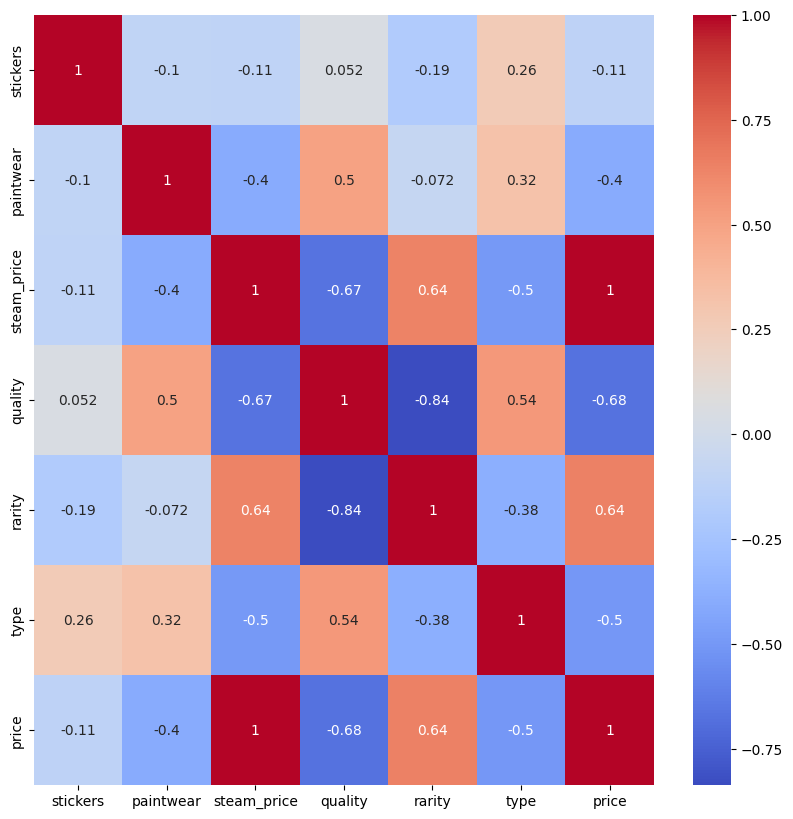

In [14]:
# Correlation heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

In [15]:
# Shuffling the data
df = df.sample(frac=1)

In [16]:
# Splitting the data into train and test

y = df["price"]
X = df.iloc[:, :7]
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

(3300, 7)
(3300,)


In [17]:
clf = tree.DecisionTreeRegressor(random_state=42, max_depth=5)
clf = clf.fit(X_train, y_train)

[Text(0.5710227272727273, 0.9166666666666666, 'steam_price <= 1.705\nsquared_error = 0.961\nsamples = 2640\nvalue = -0.014'),
 Text(0.3465909090909091, 0.75, 'steam_price <= -0.016\nsquared_error = 0.048\nsamples = 2411\nvalue = -0.31'),
 Text(0.18181818181818182, 0.5833333333333334, 'steam_price <= -0.357\nsquared_error = 0.0\nsamples = 2170\nvalue = -0.382'),
 Text(0.09090909090909091, 0.4166666666666667, 'steam_price <= -0.38\nsquared_error = 0.0\nsamples = 1944\nvalue = -0.387'),
 Text(0.045454545454545456, 0.25, 'paintwear <= -1.049\nsquared_error = 0.0\nsamples = 1457\nvalue = -0.39'),
 Text(0.022727272727272728, 0.08333333333333333, 'squared_error = 0.0\nsamples = 244\nvalue = -0.385'),
 Text(0.06818181818181818, 0.08333333333333333, 'squared_error = 0.0\nsamples = 1213\nvalue = -0.39'),
 Text(0.13636363636363635, 0.25, 'type <= 0.718\nsquared_error = 0.0\nsamples = 487\nvalue = -0.378'),
 Text(0.11363636363636363, 0.08333333333333333, 'squared_error = 0.0\nsamples = 248\nvalue 

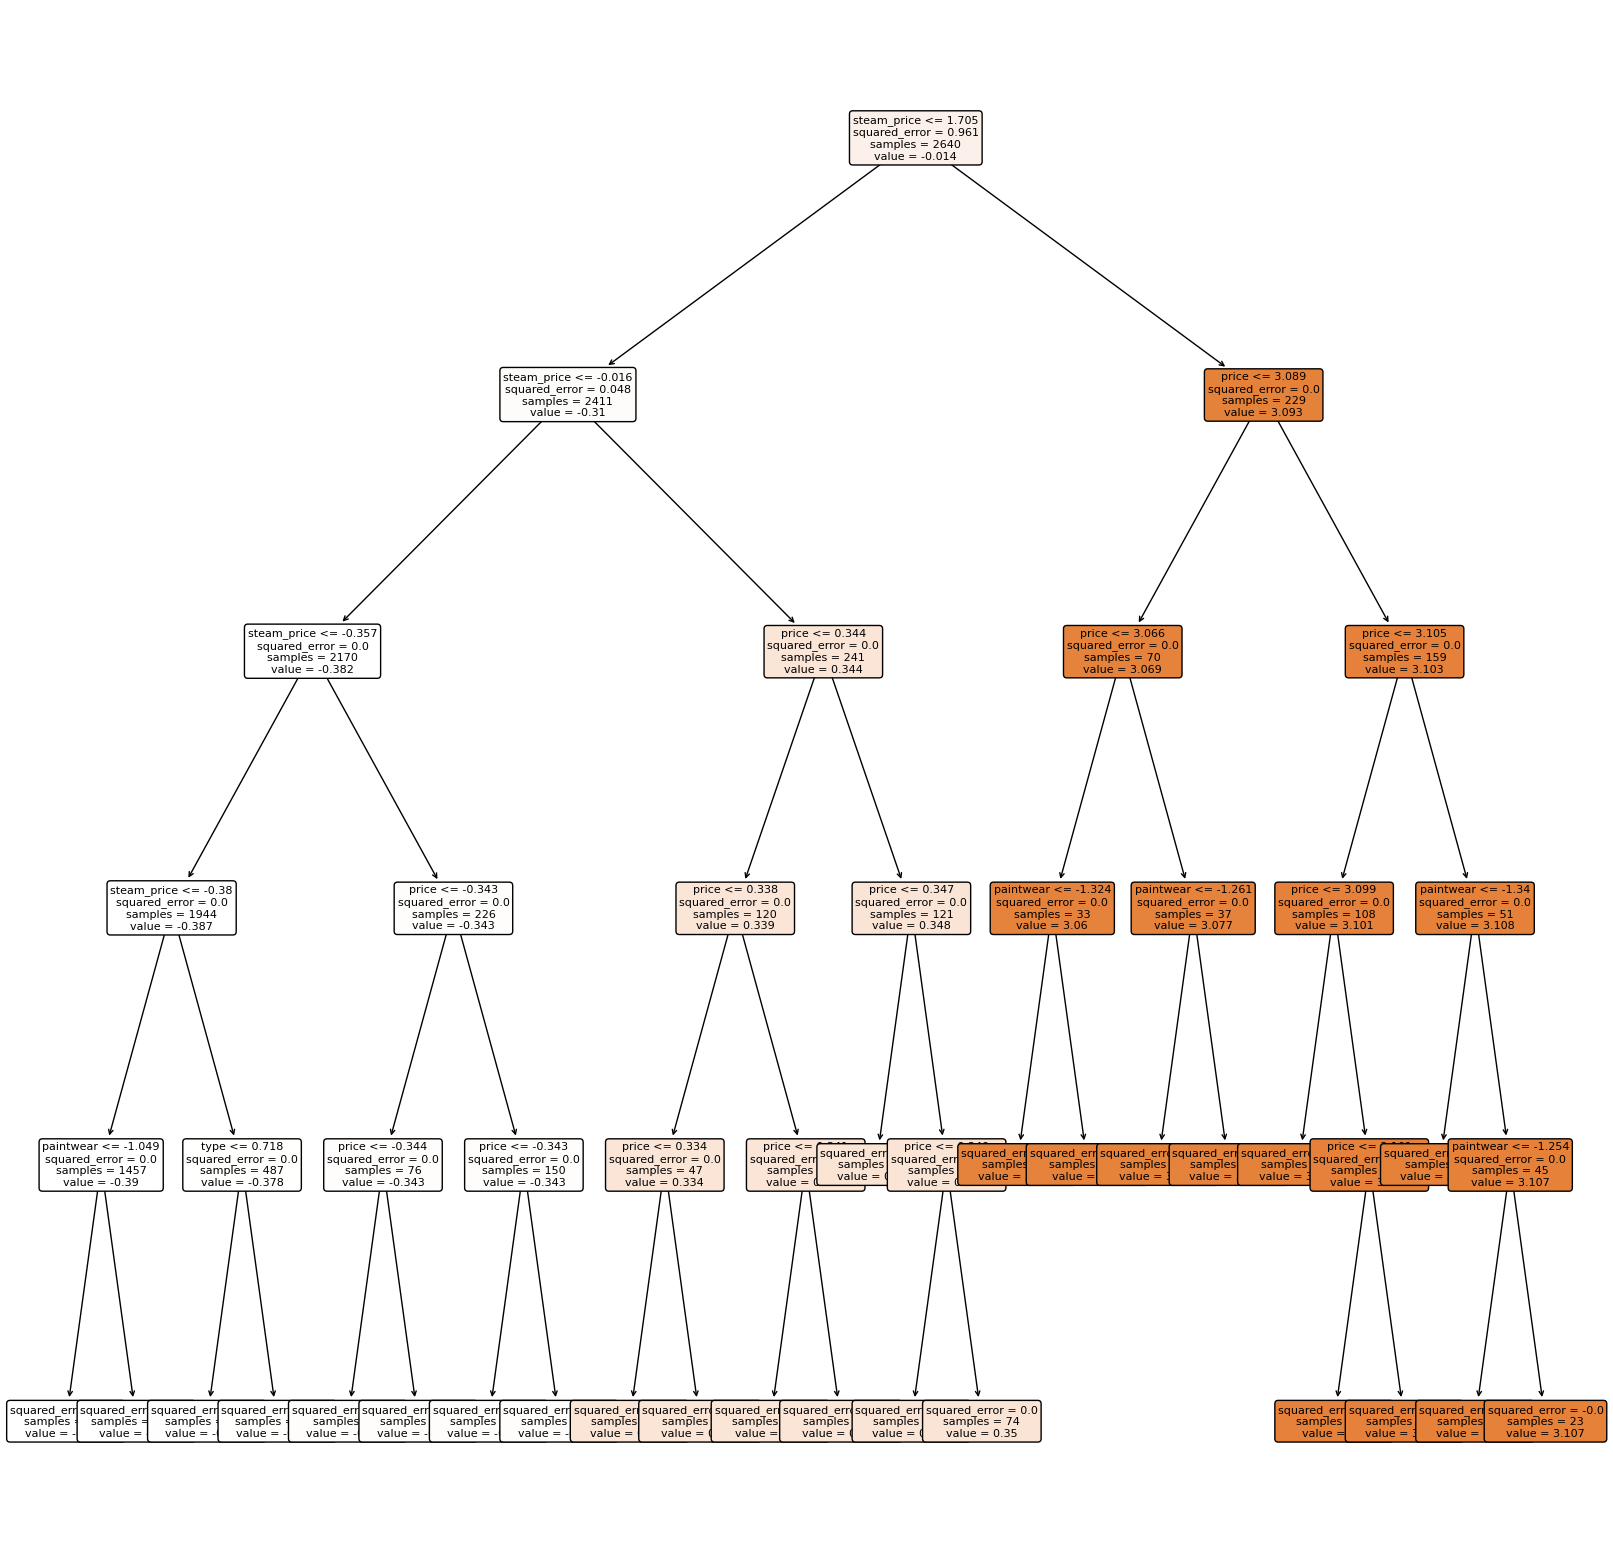

In [18]:
# Plotting the tree
plt.figure(figsize=(20, 20))
tree.plot_tree(clf, filled=True, feature_names=X.columns, rounded=True, fontsize=8)

Mean Absolute Error: 0.00042285440412735844
Root Mean Squared Error: 0.0005823470160152542
Coefficient of Determination: 1.00


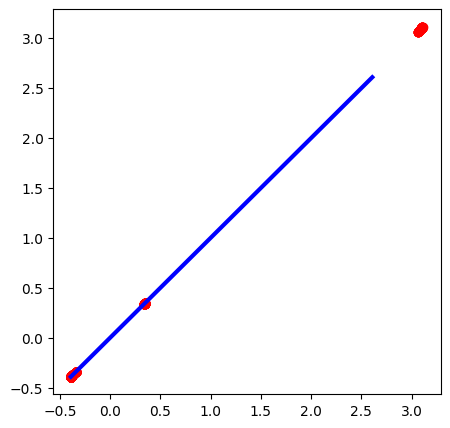

In [19]:
# Printing the metrics of the model
y_predict = clf.predict(X_test)

print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_predict))
print(
    "Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test, y_predict))
)
print("Coefficient of Determination: %.2f" % metrics.r2_score(y_test, y_predict))

# Plotting the outputs
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_predict, color="red")
plt.plot(
    np.arange(np.min(y_test), np.max(y_test)),
    np.arange(np.min(y_test), np.max(y_test)),
    color="blue",
    linewidth=3,
)
plt.show()

In [20]:
# Creating the tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float).reshape(-1, 1)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float).reshape(-1, 1)

# Creating the dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Creating the dataloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


# Creating the model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(7, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


model = MLP()

# Defining the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
# Training the model
epochs = 100
for epoch in range(epochs):
    for X, y in train_loader:
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    print("epoch {}, loss {}".format(epoch, loss.item()))

epoch 0, loss 0.0015505867777392268
epoch 1, loss 0.000273306155577302
epoch 2, loss 0.00021829429897479713
epoch 3, loss 0.00012190588313387707
epoch 4, loss 0.0001239193370565772
epoch 5, loss 3.884597754222341e-05
epoch 6, loss 5.3090152505319566e-05
epoch 7, loss 4.0737832023296505e-05
epoch 8, loss 4.498552243603626e-06
epoch 9, loss 1.1390259714971762e-05
epoch 10, loss 9.92716468317667e-06
epoch 11, loss 9.999674148275517e-06
epoch 12, loss 2.825430601660628e-05
epoch 13, loss 1.4973929864936508e-05
epoch 14, loss 7.382742296613287e-06
epoch 15, loss 1.767005232977681e-05
epoch 16, loss 6.93404672347242e-06
epoch 17, loss 1.9927370885852724e-05
epoch 18, loss 1.9678273019962944e-05
epoch 19, loss 5.801260158477817e-06
epoch 20, loss 3.768581518670544e-05
epoch 21, loss 1.809663444873877e-05
epoch 22, loss 2.8816109988838434e-05
epoch 23, loss 4.021510903839953e-05
epoch 24, loss 2.3463023808290018e-06
epoch 25, loss 7.415269465127494e-06
epoch 26, loss 4.167093266005395e-06
epoc

In [22]:
# Testing the model
with torch.no_grad():
    for X_test, y_test in test_loader:
        y_pred_MLP = model(X_test)
        loss = criterion(y_pred_MLP, y_test)
    print("Loss in the test set: {}".format(loss))

Loss in the test set: 2.805992517096456e-05


In [23]:
print("price predicted: ", y_predict[:6])
print("real price: ", y_test_tensor[:6])
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test_tensor, y_predict))
print("Mean Squared Error:", metrics.mean_squared_error(y_test_tensor, y_predict))
print(
    "Root Mean Squared Error:",
    np.sqrt(metrics.mean_squared_error(y_test_tensor, y_predict)),
)
print("Coefficient of Determination: %.2f" % metrics.r2_score(y_test_tensor, y_predict))

price predicted:  [-0.34343379  3.10310945 -0.3903483  -0.38094366 -0.3903483  -0.3903483 ]
real price:  tensor([[-0.3435],
        [ 3.1034],
        [-0.3897],
        [-0.3809],
        [-0.3913],
        [-0.3916]])
Mean Absolute Error: 0.00042285993709089044
Mean Squared Error: 3.391265313988737e-07
Root Mean Squared Error: 0.0005823457146737441
Coefficient of Determination: 1.00


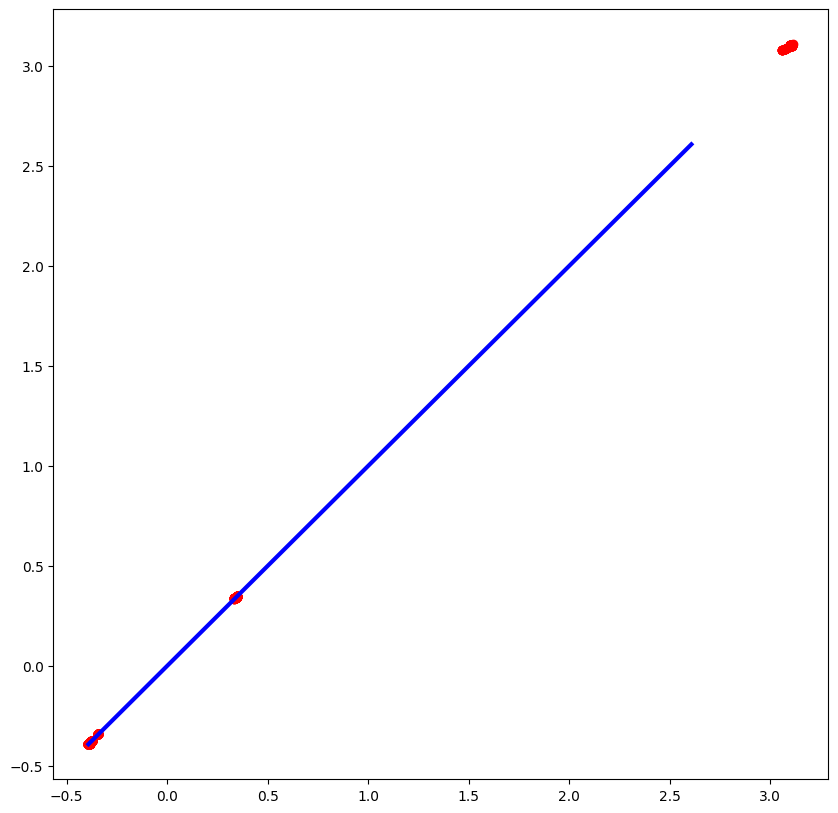

In [24]:
# Printing the metrics of the model
y_predict = model(X_test_tensor).detach().numpy()
y_test_tensor = y_test_tensor.detach().numpy()

# Plotting the outputs
plt.figure(figsize=(10, 10))
plt.scatter(y_test_tensor, y_predict, color="red")
plt.plot(
    np.arange(np.min(y_test_tensor), np.max(y_test_tensor)),
    np.arange(np.min(y_test_tensor), np.max(y_test_tensor)),
    color="blue",
    linewidth=3,
)
plt.show()

In [25]:
# Saving the model
torch.save(model.state_dict(), "../RNN_model.pt")

In [26]:
# #Loading the saved model
model = MLP()
model.load_state_dict(torch.load("../RNN_model.pt"))
model.eval()

MLP(
  (fc1): Linear(in_features=7, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

In [27]:
estimator = MLPRegressor(hidden_layer_sizes=(64, 128), max_iter=100, alpha=0.001)

# Perform cross-validation
scores = cross_val_score(estimator, X, y, cv=3)

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Print the mean and standard deviation of the scores
print("Mean score:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation scores: [ 1.74365874e-01 -1.72580356e+03  9.48595576e-01]
Mean score: -574.8935339663279
Standard deviation: 813.8163476929628


/home/mateusromani/Documents/personal/web_scrapper/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/mateusromani/Documents/personal/web_scrapper/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/mateusromani/Documents/personal/web_scrapper/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



## Linear Regression Model

### Defining the model class containing the linear regression model

In [28]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

### Preparing the data

In [29]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float).reshape(-1, 1)

# Define the number of input features and output targets
input_size = X_train.shape[1]
output_size = 1

### Instantiating the model and defining the loss function and optimizer

In [30]:
# Instantiate the model
model = LinearRegression(input_size, output_size)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = SGD(model.parameters(), lr=0.01)

### Training the model

In [31]:
num_epochs = 100

for epoch in range(num_epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/100], Loss: 0.8788
Epoch [20/100], Loss: 0.3745
Epoch [30/100], Loss: 0.2197
Epoch [40/100], Loss: 0.1523
Epoch [50/100], Loss: 0.1127
Epoch [60/100], Loss: 0.0855
Epoch [70/100], Loss: 0.0657
Epoch [80/100], Loss: 0.0509
Epoch [90/100], Loss: 0.0396
Epoch [100/100], Loss: 0.0310


### Using the model to predict

In [32]:
# Using the model to predict
with torch.no_grad():
    y_predicted = model(X_train_tensor).detach().numpy()
    y_test_tensor = y_train_tensor.detach().numpy()

print("price predicted: ", y_predicted[:6])
print("real price: ", y_test_tensor[:6])
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test_tensor, y_predicted))
print("Mean Squared Error:", metrics.mean_squared_error(y_test_tensor, y_predicted))
print(
    "Root Mean Squared Error:",
    np.sqrt(metrics.mean_squared_error(y_test_tensor, y_predicted)),
)
print(
    "Coefficient of Determination: %.2f" % metrics.r2_score(y_test_tensor, y_predicted)
)

price predicted:  [[-0.4329197 ]
 [-0.44440684]
 [-0.36938086]
 [-0.38064936]
 [-0.207735  ]
 [-0.4116724 ]]
real price:  [[-0.39134318]
 [-0.385569  ]
 [-0.37504175]
 [-0.37504175]
 [-0.3427621 ]
 [-0.38974905]]
Mean Absolute Error: 0.12172058
Mean Squared Error: 0.030308163
Root Mean Squared Error: 0.1740924
Coefficient of Determination: 0.97


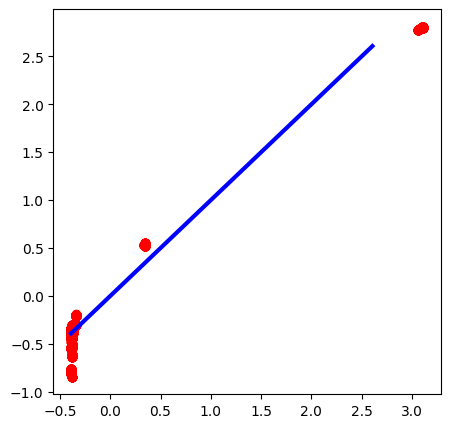

In [33]:
# Ploting graph of predicted and real values
plt.figure(figsize=(5, 5))
plt.scatter(y_test_tensor, y_predicted, color="red")
plt.plot(
    np.arange(np.min(y_test_tensor), np.max(y_test_tensor)),
    np.arange(np.min(y_test_tensor), np.max(y_test_tensor)),
    color="blue",
    linewidth=3,
)
plt.show()

In [34]:
from sklearn.base import BaseEstimator, RegressorMixin
import torch
import torch.nn as nn


class TorchLinearRegression(BaseEstimator, RegressorMixin):
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.model = nn.Linear(input_size, output_size)

    def fit(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
        criterion = nn.MSELoss()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01)

        for epoch in range(100):
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()

    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            predictions = self.model(X_tensor).numpy()
        return predictions


# Create an instance of the custom estimator
estimator = TorchLinearRegression(input_size=7, output_size=1)

# Perform cross-validation
scores = cross_val_score(estimator, X, y, cv=3)

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Print the mean and standard deviation of the scores
print("Mean score:", scores.mean())
print("Standard deviation:", scores.std())

# Saving the model
torch.save(estimator.model.state_dict(), "../Linear_model.pt")

Cross-validation scores: [-5.30611014e-02 -2.71892426e+02  3.35660434e-01]
Mean score: -90.53660889944912
Standard deviation: 128.23802629416588


/tmp/ipykernel_35037/1647505454.py:13: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_35037/1647505454.py:14: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_35037/1647505454.py:26: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_35037/1647505454.py:13: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_35037/1647505454.py:14: UserWarning:
